<a href="https://colab.research.google.com/github/Snehal-Reddy/NeuralNetPruning/blob/master/WeightBasedPruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import keras
tf.enable_eager_execution()

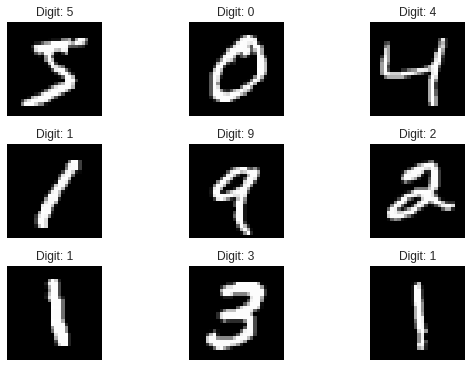

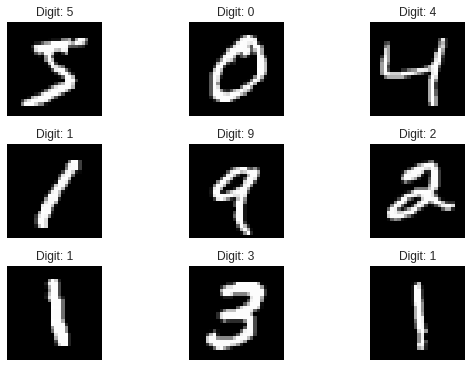

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# features, labels = next(iter(mnist))

fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(x_train[i], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [0]:
dataset_train = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_train/255, tf.float32),
    tf.cast(y_train, tf.int64)
)).shuffle(1000).batch(64)

dataset_test = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_test/255, tf.float32),
    tf.cast(y_test, tf.int64)
)).batch(64)

In [4]:
naive_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(200, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(10, use_bias=False)
])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def loss(naive_model, x, y):
    y_ = naive_model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

In [0]:
def grad(naive_model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(naive_model, inputs, targets)
    return loss_value, tape.gradient(loss_value, naive_model.trainable_variables)

In [0]:
optimizer = tf.train.AdamOptimizer()
global_step = tf.train.get_or_create_global_step()

In [10]:
from tensorflow import contrib
tfe = contrib.eager

train_loss_results = []
train_accuracy_results = []

epoch_num = 5

for epoch in range(epoch_num):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    
    for x, y in (dataset_train):
        outputs = naive_model(x)
        loss_value, grads = grad(naive_model, x, y)
        optimizer.apply_gradients(zip(grads, naive_model.trainable_variables),global_step)  
        
        epoch_loss_avg(loss_value)  
#         epoch_accuracy(tf.argmax(naive_model(x), axis=1, output_type=tf.int32), y)
        epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
    
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
        
#         with tf.GradientTape() as tape:
#             outputs = model(x)
#             loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), outputs)
#         grads = tape.gradient(loss, model.trainable_weights)
#         optimizer.apply_gradients(zip(grads, model.trainable_weights), global_step)
#         epoch_loss_avg(loss)
#         epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
#     training_losses.append(epoch_loss_avg.result())
#     training_accuracies.append(epoch_accuracy.result())

Epoch 000: Loss: 0.021, Accuracy: 99.370%


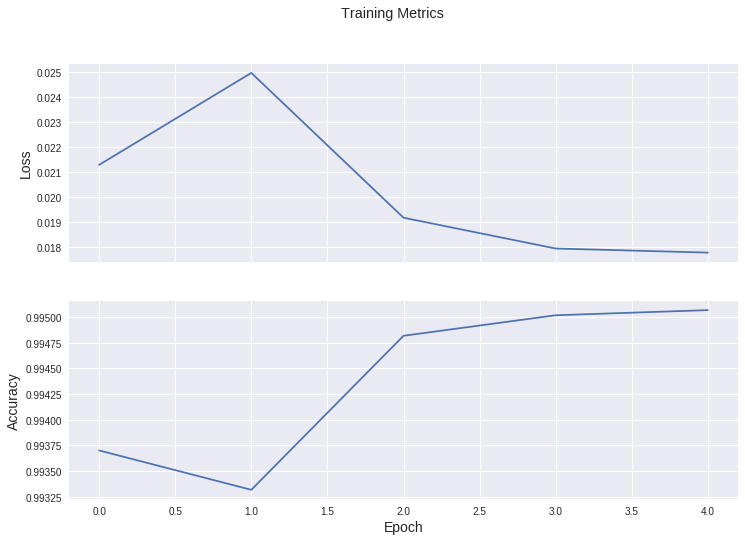

In [11]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results);

In [14]:
epoch_loss_avg = tfe.metrics.Mean()
epoch_accuracy = tfe.metrics.Accuracy()
for x, y in dataset_test:
    outputs = naive_model(x)
    loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), outputs)
    epoch_loss_avg(loss)
    epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
result = epoch_loss_avg.result().numpy(), epoch_accuracy.result().numpy()
result


(0.09708532494142036, 0.9837)

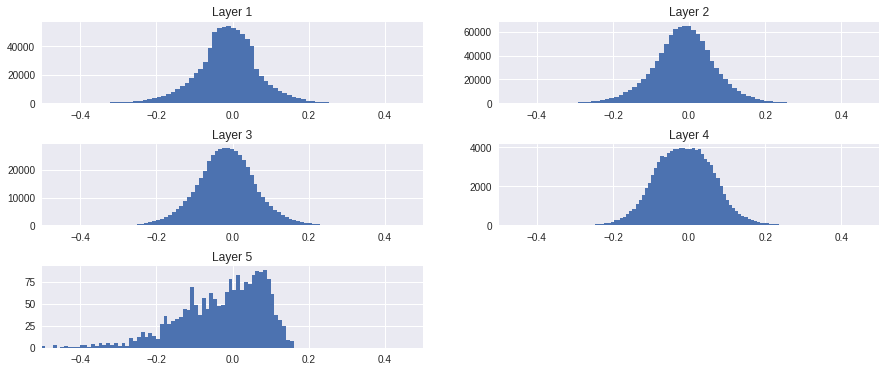

In [16]:
plt.figure(1, figsize=(15,6))
plt.subplots_adjust(hspace=0.5)
for i, weights in enumerate(naive_model.trainable_weights):
    plt.subplot(3,2,i+1)
    plt.title("Layer {}".format(i+1))
    plt.hist(weights.numpy().reshape(-1), bins=100)
    plt.xlim(-0.5, 0.5);